# Processamento de Linguagem Natural (NLP)

Professor: Arlindo Galvão

Data: 09/09/2024

## Cronograma

* Implemente diversos tipos de atenção

### **Implementando RNN Seq2Seq sem atenção**

In [67]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import seaborn as sns
import random

**Teremos 4 classes principais:**
- **Tokenizer:** mapeia nosso input textual para o input do modelo;
- **Encoder:** realiza o encoding do input;
- **Decoder:** realiza a decodificação a partir do hidden state anterior (com a possibilidade de attention);
- **Seq2seq:** encapsula nosso Encoder e nosso Decoder, e transforma do espaço latente para o token id.

**Tokenizer:** Aqui que iremos trabalhar com nossos dados de entrada. Todos os tratamentos iremos fazer por meio desta classe.

In [2]:
class Tokenizer():
    def __init__(self):
        self.tokens_special = ["<sos>", "<eos>", "<oov>",]
        self.vocab_input = self.tokens_special[:]
        self.vocab_output = self.tokens_special[:]
        self.len_vocab_input = len(self.vocab_input)
        self.len_vocab_output = len(self.vocab_output)

        self.SOS_ID = self.tokens_special.index("<sos>") # start of sentence
        self.EOS_ID = self.tokens_special.index("<eos>") # end of sentence
        self.OOV_ID = self.tokens_special.index("<oov>") # out of vocabulary


    def add_input_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_input:
                self.vocab_input.append(token)
        self.len_vocab_input = len(self.vocab_input)


    def add_output_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_output:
                self.vocab_output.append(token)
        self.len_vocab_output = len(self.vocab_output)


    def tokens2inputs_id(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()

        inputs_id = [self.SOS_ID]

        for token in tokens:
            if token in self.vocab_input:
                inputs_id.append(self.vocab_input.index(token))
            else:
                inputs_id.append(self.OOV_ID)
        return torch.tensor(inputs_id)


    def tokens2outputs_id(self, tokens):
        outputs_id = []
        for token in tokens:
            if token in self.vocab_output:
                outputs_id.append(self.vocab_output.index(token))
            else:
                outputs_id.append(self.OOV_ID)
        outputs_id.append(self.EOS_ID)
        return torch.tensor(outputs_id)


    def outputs_id2text(self, outputs_id):
        if type(outputs_id) == int:
            outputs_id = [outputs_id]
        text = ""
        for id in outputs_id:
            text += self.vocab_output[id]
        return text

**Encoder:** Aqui que ocorrerá o processamento do nosso input.

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

**Decoder:** A partir das representações geradas pelo Encoder, nós iremos gerar nosso output utilizando esta classe.

> OBS: Ao utilizar esta classe com use_attention=True, estamos concatenando o attention ao embedding do token, e não ao hidden state.

In [4]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=False):
        super(Decoder, self).__init__()
        self.output_vocab_size = output_vocab_size
        self.embedding = nn.Embedding(output_vocab_size, emb_dim)
        self.use_attention = use_attention
        if self.use_attention:
            self.rnn = nn.RNN(emb_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout)
        else:
            self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, attention=None):
        embedded = self.dropout(self.embedding(input))
        if self.use_attention:
            embedded = torch.cat((embedded, attention), dim=1)

        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

**Seq2Seq:** Esta classe vai encapsular nosso Encoder e nosso Decoder, realizando o fluxo do nosso modelo. Também é nela que ocorrerá a linear + softmax para obter a distribuição de probabilidade de tokens.

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state)
        output = self.fc_out(output)
        output_distribution = F.softmax(output, dim=1)
        return output_distribution, hidden

Agora, vamos configurar e utilizar nosso modelo

In [6]:
EMB_DIM = 16
HIDDEN_DIM = 16
N_LAYERS = 1
DROPOUT = 0.0
MAX_STEPS = 10

tokenizer = Tokenizer()
inputs = ["a", "b", "c", "d"]
outputs = ["1", "2", "3", "4"]
tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [7]:
model = Seq2Seq(tokenizer.len_vocab_input, tokenizer.len_vocab_output, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
# Vamos printar nossa arquitetura, veremos que possui um encoder, um decoder e uma linear ao final
print(model)

In [8]:
input = "a b c d"
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {input}")
print(f"Saída: {tokenizer.outputs_id2text(outputs_ids)}")

Como nosso modelo ainda não foi treinado, é esperado que sua saída seja aleatória. Como não removemos nenhum token especial, também é possível que sua saída possua tokens especiais (como o token \<sos\> em posições além do começo da sentença).

#### **IMPLEMENTANDO O TREINAMENTO**

Abaixo está o código que realiza o treinamento do modelo. Neste exemplo, estamos mapeando modelo para traduzir cada letra para seu correspondente numérico (a:1, b:2, c:3, d:4, e:5)


Ex.
> Input: ["a", "b", "c", "d", "e"]<br>
> Output: "1 2 3 4 5"

In [9]:
# Instanciando o Tokenizer
tokenizer = Tokenizer()

# Adiciona as letras ao vocabulário do Tokenizer
inputs = ["a", "b", "c", "d", "e"]
outputs = [str(i+1) for i, _ in enumerate(inputs)] # Mapeando letras para números como strings

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

def get_random_sample():
    num_char_input = np.random.randint(1,4) # vamos escolher aleatoriamente entre 1 e 3 char para input (pode ser a, ab, abc)
    sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input) # vamos escolher nossos caracteres aleatoriamente, mas sem escolher tokens especiais
    sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
    sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
    return sampled_inputs, sampled_outputs  # Repare que o join do input nao tem espaço e o do output tem, pois vamos querer que ele gere também os espaços.

In [10]:
# Definir parâmetros
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

# Instanciar o modelo
model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [11]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Função de treino
def train(model, tokenizer, criterion, optimizer, num_steps):
    history = {'total_steps': 0, 'loss': []}
    model.train()

    for step in range(num_steps):
        optimizer.zero_grad()

        # Exemplo de entrada e saída
        input_text, output_text = get_random_sample()

        # Converte o texto de entrada e saída para IDs
        inputs_id = tokenizer.tokens2inputs_id(input_text)
        output_target_id = tokenizer.tokens2outputs_id(output_text)
        input_id_decoder = torch.tensor([tokenizer.SOS_ID])

        # Forward pass
        loss = 0
        decoder_hidden_state = None
        for target_id in output_target_id:
            output_distribution, decoder_hidden_state = model(inputs_id_encoder=inputs_id,
                                                              input_id_decoder=input_id_decoder,
                                                              decoder_hidden_state=decoder_hidden_state)

            result_tensor = torch.zeros(tokenizer.len_vocab_output, dtype=torch.float)
            result_tensor[target_id] = 1

            # Calcula a perda, Cross Entropy entre predições e targets (precisamos do unsqueeze para adicionar a dimensão do batch no nosso result_tensor)
            loss += criterion(output_distribution, result_tensor.unsqueeze(0))

            # O próximo input do decoder será o token gerado pelo decoder atual
            input_id_decoder = torch.argmax(output_distribution, dim=1)

        # Salvando o historico de informações sobre o treinamento
        history['loss'].append(loss.item())
        history['total_steps'] += 1

        # Backpropagation
        loss.backward()
        optimizer.step()

        if step % 250 == 0:
            print(f'Epoch {step}/{num_steps}, Loss: {loss.item():.4f}')
    return history

# Treinar o modelo
history = train(model, tokenizer, criterion, optimizer, num_steps)

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    # Vamos fazer uma média para tentar lidar melhor com outliers (loss muito alta em meio à losses baixar ou vice-versa)
    mean_steps = 20
    mean_loss_n_steps = [sum(history['loss'][i:i+mean_steps])/mean_steps for i in range(0,history['total_steps'],mean_steps)]
    plt.plot(list(range(0,history['total_steps'],mean_steps)), mean_loss_n_steps)

    plt.title('Loss Curve')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [13]:
plot_loss(history)

Testando com inputs:

In [14]:
input = ["a", "c"]
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {' - '.join(input)}")
print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

Parece que nosso modelo aprendeu algo :)

#### **Teste!**
Brinque com os parâmetros, dados de input e output, e teste o modelo. Entenda o que está acontecendo.

Exemplo: Como ele se comportaria caso tentassemos fazer com todo o alfabeto? E se mudassemos a quantidade máxima de tokens que o encoder é treinado?

1º Teste: Adicionar algumas letras ao alfabeto

In [16]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

def get_random_sample():
    num_char_input = np.random.randint(1,4)
    sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input)
    sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
    sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
    return sampled_inputs, sampled_outputs

In [18]:
sampled_inputs, sampled_outputs = get_random_sample()

In [19]:
sampled_inputs, sampled_outputs

In [30]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 64
hidden_dim = 128
n_layers = 4
dropout = 0.2
learning_rate = 0.0001
num_steps = 50000

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train(model, tokenizer, criterion, optimizer, num_steps)

In [32]:
plot_loss(history)

In [188]:
def test_model(model, tokenizer_model, input):
    enc_inp = tokenizer_model.tokens2inputs_id(input)
    hidden_state = None
    token_id = torch.tensor([tokenizer_model.SOS_ID])
    outputs_ids = []

    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
        outputs_ids.append(token_id.item())
        if token_id.item() == tokenizer_model.EOS_ID:
            break

    print(f"Entrada: {' - '.join(input)}")
    print(f"Saída: {' - '.join([tokenizer_model.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

In [34]:
test_model(model, tokenizer, ["b", "a", "c"])

Percebi que:
Temos que reinstanciar o otimizador para que o modelo treine na célula de teste. Além disso, aumentar o vocabulário torna necessário aumentar o número de steps para que o modelo aprenda, para 5000 steps (como treinado no anterior) não funcionou bem. Outro ponto, é que fizemos o modelo ser treinado com sequências de tamanho máximo igual a 3. Com isso, não otimizamos a produção de um hidden_state representativo para sequências maiores, e assim, se testado em uma sequência maior, dificilmente irá funcionar bem.

2º Teste: Alfabeto completo

In [35]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [36]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

In [37]:
plot_loss(history)

In [40]:
test_model(model, tokenizer, ["a", "b", "b"])

---

## **ATIVIDADE**

#### **INSTRUÇÕES**

- **FOQUE EM ALTERAR APENAS A CLASSE Seq2Seq.** Caso necessário, faça alterações mínimas nas outras partes do código e documente a motivação. A ideia não é reestruturar o código, mas complementá-lo. <br><br>
- **DOCUMENTE SEU PASSO A PASSO POR MEIO DE CÉLULAS DE TEXTO.** Não utilize de grandes comentários no seu código. Utilize das ferramentas do markdown para fazer comentários, destacar, colar imagens, etc. para documentar seus avanços.<br><br>
- **NÃO EXCLUA OS OUTPUTS.** Ao entregar este notebook, não exclua o output final das células, mantenha os resultados, loss, gráficos e o que julgar necessário para entendimento do seu progresso.<br><br>
- **É PERMITIDO O USO DE LLM (ex: ChatGPT).** Documente seus prompts e como o modelo te ajudou (substitua grandes partes por placeholders na documentação, por exemplo, caso tenha colado a classe Seq2Seq, na documentação escreva "Prompt: por favor, me ajude a entender a seguinte classe: [Classe Seq2Seq]"). Cite como o LLM te ajudou em textos, não apenas colando a resposta por ele (ex: Com este prompt, o LLM me ajudou a entender ... e gerar a parte do código referente à ..., mas com erro em ...).

**Documente aqui quais LLMs foram utiliazdos:** (ex: ChatGPT)<br>

Após estabelecer a linha de racíocinio do que faria para responder a primeira questão, vi que seria necessário acessar cada hidden do encoder e o hidden do encoder. Com isso, investiguei mais o código e achei as variáveis: encoder_hidden_states, decoder_hidden_state. Ao investigar, vi que minha encoder_hidden_states fornecia exatamente o hidden para cada "step de tempo", cada token +hidden anterior de entrada na rede. Contudo, vi também que o hidden do decoder vinha com uma dimensão maior que a esperada (esperava um único vetor do hidden naquele timestamp) porém, vi que vinham 2, o último vetor era como o esperado, mas o primeiro não.
 
Usei o Chat-gpt para me tirar essa dúvida:
1 - Enviei um prompt pedindo para me explicar o por que desse retorno do hidden do decoder ter dimensão maior que 1 (passei parcela do código necessária) 
Resposta: Dentro da resposta, uma das possibilidades destacadas, é que como foram definidas 2 camadas, ele me retornava o hidden para cada camada do decoder, enquanto no encoder, era apenas o hidden final daquele timstamp. 

Com isso, fiz alguns testes com o número de camadas e vi que de fato ele se comportava como descrito, para sanar 100 por cento a dúvida, abri a documentação no seguinte link: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html, e vi que realmente era isso na seguinte linha: "`h_n`: tensor de forma `(D * num_layers, H_out)` para entradas sem batch ou `(D * num_layers, N, H_out)` contendo o estado oculto final para cada elemento no batch. Como estamos sem batches, temos o shape (num_layerrs, H_out) (nosso D é igual a 1, pois não é bidirecional). Assim, para os cálculos da atenção consideraremos o hidden do decoder como o hidden da última camada.
"

REFERÊNCIAS:

https://www.youtube.com/watch?v=94hG00EJFNo&list=PLSZEVLiOtIgF19_cPrvhJC2bWn-dUh1zB&index=7

https://pt.d2l.ai/chapter_attention-mechanisms/attention-scoring-functions.html


##### **A partir das classes estabelecidas e do código de treinamento, modifique a classe Seq2Seq para responder as questões seguintes:**

#### **Questão 1**
Altere a classe Seq2Seq para implementar uma attention através da média dos hidden states do encoder (semelhante à gerar um attention score igual à todos os hidden states do encoder). Mantenha a concatenação entre o attention output e o embedding como na classe Decoder originalmente implementada. Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

IF DECODER... VERIFICA SE JÁ PROCESSAMOS O ENCODER, ASSIM QUE PROCESSAMOS O ENCODER, INICIALIZAMOS O DECODER, E NO PROXIMO STEP FORA DO IF TEMOS O PROXIMO STEP DO DECODER (isso em uma nova chamada do foward) VERIFICAR ISSO QUANDO FOR CALCULAR ATTENTION

Para o código abaixo temos as seguintes alterações:

1. Adicionamos a variável `self.attention` para armazenar a média dos hidden states do encoder. Como o valor do attention não depende da entrada do decoder, ele é calculado apenas na primeira chamada do forward. Após isso, fica guardado, claro para o processamento de uma sequência.

2. No foward, recebemos os inputs_id (tensor que representa a entrada, ou seja, a sequência de tokens de entrada), o input_id_decoder (tensor que representa o token de entrada do decoder) e o decoder_hidden_state (tensor que representa o hidden state do decoder). Se o decoder_hidden_state for None, significa que estamos no primeiro passo do decoder, então precisamos processar o encoder. Para isso, chamamos o encoder com os inputs_id e guardamos os hidden states do encoder em `encoder_hidden_states` e o hidden state final do encoder em `decoder_hidden_state`. Calculamos a média dos hidden states do encoder e guardamos em `self.attention`.

In [279]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.attention = None #inicialização do attention
        self.attention_scores = []


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.attention = torch.mean(encoder_hidden_states, dim=0, dtype=torch.float32).unsqueeze(0) # Faz a média dos hidden do encoder 

            seq_len = encoder_hidden_states.size(0)
            self.attention_scores = torch.ones(seq_len) / seq_len  # Shape: (seq_len,)
                
            


        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=self.attention)
        output = self.fc_out(output)

        '''A FUNÇÃO SOTMAX JÁ ESTÁ PRESENTE NO CÁLCULO DA LOSS, ISSO PODE ATRAPALHAR O TREINO,
        A LINHA ABAIXO RETORNAVA O TOKEN DE MAIOR PROBABILIDADE, PORÉM, PARA O CÁLCULO DA LOSS QUEREMOS A PROBABILIDADE DE CADA TOKEN'''
        #output_distribution = F.softmax(output, dim=1) A FUNÇÃO SOTMAX JÁ ESTÁ PRESENTE NO CÁLCULO DA LOSS, ISSO PODE ATRAPALHAR O TREINO
        #token_id = torch.argmax(output_distribution, dim=1) ESSA LINHA RETORNAVA O TOKEN DE MAIOR PROBABILIDADE, PORÉM, PARA O CÁLCULO DA LOSS QUEREMOS A PROBABILIDADE DE CADA TOKEN
        
        return output, hidden

##### Alfabeto completo (modelo 1)

In [280]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [281]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

In [282]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

In [283]:
plot_loss(history)

In [284]:
test_model(model1, tokenizer, ["a", "b", "c"])

#### Alfabeto até F (modelo 2)

In [285]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [286]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

In [287]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

In [288]:
plot_loss(history)

In [289]:
test_model(model2, tokenizer, ["a", "b", "c"])

##### **Mapa de atenção**

In [290]:
def plot_attention(model, tokenizer, input=["a", "b", "c"]):
    enc_inp = tokenizer.tokens2inputs_id(input)
    hidden_state = None
    token_id = torch.tensor([tokenizer.SOS_ID])
    outputs_ids = []

    attention_matrix = []
    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)
        token_id_value = token_id.item()

        if token_id_value >= len(tokenizer.vocab_output):
            token_id_value = tokenizer.OOV_ID

        outputs_ids.append(token_id_value)
        attention_matrix.append(model.attention_scores)

        if token_id_value == tokenizer.EOS_ID:
            break

    print(f"Entrada: {' - '.join(input)}")
    print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

    num_output_tokens = len(outputs_ids)
    num_input_tokens = len(enc_inp)

    attention_matrix_np = np.stack([score.detach().numpy() for score in attention_matrix])

    attention_matrix_np = attention_matrix_np[:num_output_tokens, :num_input_tokens]


    print("Input IDs:", enc_inp)
    print("Input Tokens:", [tokenizer.vocab_input[i] for i in enc_inp])
    print("Output IDs:", outputs_ids)
    print("Output Tokens:", [tokenizer.outputs_id2text(i) for i in outputs_ids])

    for i, attention_scores in enumerate(attention_matrix):
        print(f"Attention scores for output token {i}: {attention_scores}")


    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        attention_matrix_np,
        annot=True,
        cmap='Blues',
        xticklabels=[tokenizer.vocab_input[i] for i in enc_inp],
        yticklabels=[tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))],
        cbar=True
    )

    plt.xlabel('Tokens de Entrada')
    plt.ylabel('Tokens de Saída')
    plt.title('Mapa de Atenção - Tokens de Entrada x Tokens de Saída')

    plt.show()


plot_attention(model2, tokenizer, input=["a", "b", "c"])

#### **Questão 2**
Altere a classe que você criou na Questão 1 para que o Attention Output seja concatenado com o hidden state do decoder (e não com o embedding). Após isso, treine o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:

- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

> **Dica:** Não utilize a atenção implementada na classe Decoder, mas implemente o que for necessário na classe Seq2Seq.

In [291]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=False)
        self.fc_out = nn.Linear(2*hidden_dim, output_vocab_size) #alteração para 2*hidden_dim, pois passaremos a concatenar o attention com o hidden do decoder
        self.attention = None #inicialização do attention
        self.attention_scores = []


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.attention = torch.mean(encoder_hidden_states, dim=0, dtype=torch.float32).unsqueeze(0) # Faz a média dos hidden do encoder 

            seq_len = encoder_hidden_states.size(0)
            self.attention_scores = torch.ones(seq_len) / seq_len  # Shape: (seq_len,)




        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=None)

        attention_hidden = torch.cat((output, self.attention), dim=1)
        
        output = self.fc_out(attention_hidden)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [292]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [293]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

In [294]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

In [295]:
plot_loss(history)

In [296]:
test_model(model1, tokenizer, ["a", "b", "c"])

#### Alfabeto até F (modelo 2)

In [297]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [298]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

In [299]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

In [300]:
plot_loss(history)

In [301]:
test_model(model2, tokenizer, ["a", "b", "c"])

In [302]:
plot_attention(model2, tokenizer, input=["a", "b", "c"])

#### **Questão 3**

Implemente o mecanismo de atenção de  Bahdanau et al. (2015). Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

Nesse caso, é importante salvar os hiddens do decoder para cada timestep, pois precisaremos deles para calcular o attention score. Além disso, precisamos calcular o attention score para cada timestep do decoder, e não apenas para o último timestep. Esse attention será feito usando o hidden do decoder e os hiddens do encoder. O attention score será calculado para cada timestep do decoder e será usado para ponderar os hiddens do encoder. O output do attention será a concatenação do hidden do decoder com o hidden ponderado do encoder.

In [303]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        
        self.hiddens_decoder = [] #inicialização dos hiddens do decoder
        
        self.attention_scores = []
        


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.hiddens_decoder = encoder_hidden_states


        self.attention_scores = []
        hidden_decoder = decoder_hidden_state[-1] # Pegamos o hidden da última camada do decoder
        
        for i in range(len(self.hiddens_decoder)): # Para cada vetor no hidden
            hidden_encoder = self.hiddens_decoder[i]
            attention_score = torch.dot(hidden_decoder, hidden_encoder) # Calcula o attention score como produto interno do hidden_encoder e hidden_decoder
            self.attention_scores.append(attention_score)
            
        self.attention_scores = F.softmax(torch.stack(self.attention_scores), dim=0) # Softmax para obter os pesos do attention
        
        attention_vec = torch.sum(self.attention_scores.unsqueeze(1) * self.hiddens_decoder, dim=0).unsqueeze(0) # Multiplica os pesos do attention com os hiddens do encoder



        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [317]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [318]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

In [319]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

In [320]:
plot_loss(history)

In [321]:
test_model(model1, tokenizer, ["a", "b", "c"])

#### Alfabeto até F (modelo 2)

In [324]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [325]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 10000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

In [326]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

In [327]:
plot_loss(history)

In [328]:
test_model(model2, tokenizer, ["a", "b", "c"])

In [329]:
plot_attention(model2, tokenizer, input=["a", "b", "c"])

#### **Questão 4**
Implemente a "??? Attention" apresentada durante a aula.  Após isso, treine dois modelos com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

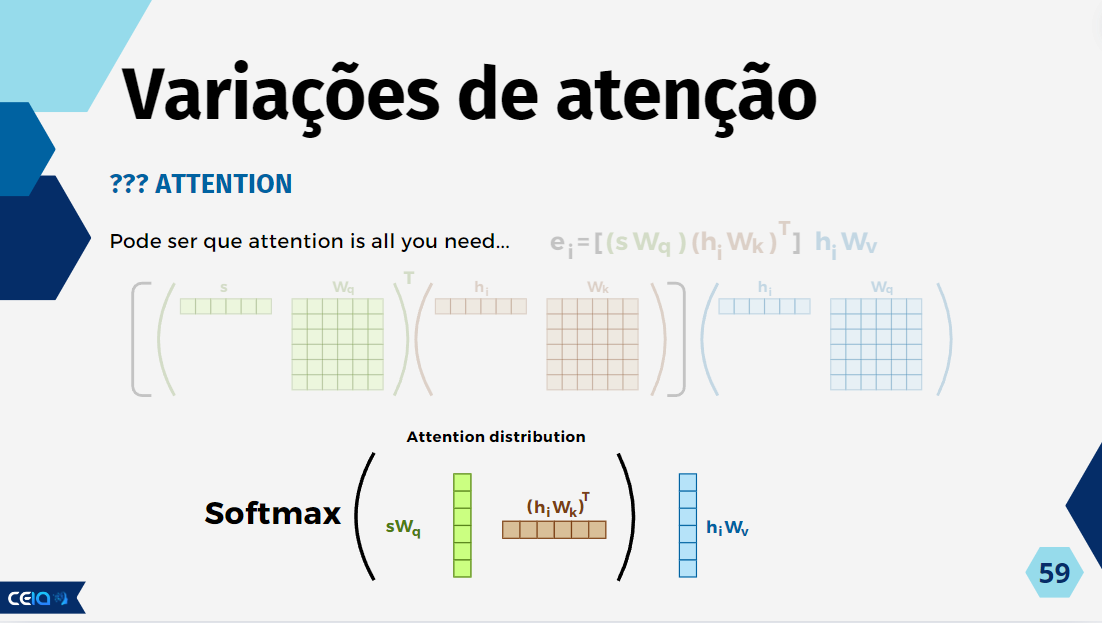

In [330]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        
        self.q = nn.Linear(hidden_dim, hidden_dim)
        self.k = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, hidden_dim)

        self.hiddens_decoder = [] #inicialização dos hiddens do decoder

        self.attention_scores = []



    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.hiddens_decoder = encoder_hidden_states


        self.attention_scores = []
        hidden_decoder = decoder_hidden_state[-1] # Pegamos o hidden da última camada do decoder

        for i in range(len(self.hiddens_decoder)): # Para cada vetor no hidden
            
            q_vector = self.q(hidden_decoder)
            k_vector = self.k(self.hiddens_decoder[i])
            
            attention_score = torch.dot(q_vector, k_vector)
            self.attention_scores.append(attention_score)
            

        self.attention_scores = F.softmax(torch.stack(self.attention_scores), dim=0) # Softmax para obter os pesos do attention

        attention_vec = torch.sum(self.attention_scores.unsqueeze(1) * self.v(self.hiddens_decoder), dim=0).unsqueeze(0) # Multiplica os pesos do attention com os hiddens do encoder


        
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)

        return output, hidden

##### Alfabeto completo (modelo 1)

In [332]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
    "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [333]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

In [334]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

In [335]:
plot_loss(history)

In [337]:
test_model(model1, tokenizer, ["d", "b", "c"])

##### Alfabeto até a letra "f" (modelo 2)

In [338]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [339]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 10000

model2 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model2

In [340]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
history = train(model2, tokenizer, criterion, optimizer, num_steps)

In [341]:
plot_loss(history)

In [342]:
test_model(model2, tokenizer, ["d", "b", "c"])

In [344]:
plot_attention(model2, tokenizer, ["a", "b", "c"])

#### **Questão 5**
A partir das suas descobertas nas Questões 3 e 4,  explore a criação de duas novas classes: "class BahdanauAttention" (com a atenção de Bahdanau) e "class WhatAttention" (com a ??? Attention). Após criá-las, adicione à classe Seq2Seq. Insira um novo parâmetro na classe Seq2Seq para permitir escolher qual attention deve-se utilizar (attention_implementation="bahdanau" para atenção de Bahdanau ou attention_implementation="qkv_attention" para ??? Attention)

> Dica: Observe a criação das classes Encoder e Decoder e como foram inseridas dentro da classe Seq2Seq

In [394]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        
    def forward(self, hidden, encoder_outputs):
        attention_scores = []
        
        for i in range(len(encoder_outputs)):
            attention_score = torch.dot(hidden, encoder_outputs[i])
            attention_scores.append(attention_score)
            
        attention_scores = F.softmax(torch.stack(attention_scores), dim=0)
        
        attention_vec = torch.sum(attention_scores.unsqueeze(1) * encoder_outputs, dim=0).unsqueeze(0)
        
        return attention_vec, attention_scores


In [395]:
class WhatAttention(nn.Module):
    def __init__(self, hidden_size):
        super(WhatAttention, self).__init__()
        self.hidden_size = hidden_size
        
        self.q = nn.Linear(hidden_size, hidden_size)
        self.k = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, hidden, encoder_outputs):
        attention_scores = []
        
        for i in range(len(encoder_outputs)):
            q_vector = self.q(hidden)
            k_vector = self.k(encoder_outputs[i])
            
            attention_score = torch.dot(q_vector, k_vector)
            attention_scores.append(attention_score)
            
        attention_scores = F.softmax(torch.stack(attention_scores), dim=0)
        
        attention_vec = torch.sum(attention_scores.unsqueeze(1) * self.v(encoder_outputs), dim=0).unsqueeze(0)
        
        return attention_vec, attention_scores

In [406]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, attention_implementation="qkv_attention", sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.encoder_hidden_states = []
        
        self.attention_scores = []
        
        if attention_implementation == "bahdanau":
            self.attention = BahdanauAttention(hidden_dim)
        elif attention_implementation == "qkv_attention":
            self.attention = WhatAttention(hidden_dim)
        else:
            raise ValueError("Invalid attention implementation")
        
    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None, attention_scores=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
            self.encoder_hidden_states = encoder_hidden_states
        
        hidden_decoder = decoder_hidden_state[-1]
        
        attention_vec, attention_scores = self.attention(hidden_decoder, self.encoder_hidden_states)
        
        self.attention_scores = attention_scores
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_vec)
        output = self.fc_out(output)
        
        return output, hidden

In [407]:
tokenizer = Tokenizer()

inputs = [
    "a", "b", "c", "d", "e", "f"
]

outputs = [str(i + 1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output

In [408]:
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

model1 = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
model1

In [409]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
history = train(model1, tokenizer, criterion, optimizer, num_steps)

In [410]:
test_model(model1, tokenizer, ["d", "b", "c"])

In [411]:
plot_attention(model1, tokenizer, ["d", "b", "c"])

#### **Comentários finais**

- Relate aqui seus achados, dificuldades encontradas durante o processo, percepções sobre o tema, e demais comentários que gostaria de realizar.

Comentários: